# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.3 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [7]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [2]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from unityagents import UnityEnvironment
from agent import Agent
import pdb

In [3]:
# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# get size of states in the environment
states = env_info.vector_observations
state_size = states.shape[1]
agents_nb = len(env_info.agents)
# get amount of possible actions in the environment
action_size = brain.vector_action_space_size

In [5]:
#initialize each agent with double state_size so that they can be trained using the full state of 2x24 = 48
agents = [Agent(state_size=state_size*2,action_size=action_size,random_seed=1) for _ in range(agents_nb)]

In [6]:
def ddpg_multiple(n_episodes=10000, max_t=1000, print_every=10):

    scores_deque = deque(maxlen=100)
    
    hist = []
    
    for i_episode in range(1, n_episodes+1):
        
        #reset the environment and get the current states
        env_info = env.reset(train_mode=True)[brain_name]
        
        #reset the agents
        for agent in agents:
            agent.reset()
        
        # get the states of the environment associated to each of the 2 agents
        states = env_info.vector_observations
        
        # reshape states to have a vector of lenghth = 2*24 = 48
        states = np.reshape(states,(1,48))
        ##
        
        scores = np.zeros(agents_nb)
               
    
        for t in range(max_t):

            
            #get actions for each of the two agents, with respect to the global states
            action1 = agents[0].act(states, add_noise=True)
            action2 = agents[1].act(states, add_noise=True)
            #concatenate the two actions into a vector of size 1*4 = 4
            actions = np.concatenate((action1, action2)).flatten().reshape((1,4))
            
            #pass the concatenated actions vector the environment to get next_states,rewards, dones
            env_info = env.step(actions)[brain_name]        # send the actions to the environment
            
            next_states = env_info.vector_observations   # get the next state for each agent           
            
            #next_states is also reshaped to a vector of size 48
            next_states = np.reshape(next_states, (1, 48))
            ##
            
            rewards = np.array(env_info.rewards)                 # get the reward for each agent
            dones = np.array(env_info.local_done)                # see if episode has finished
            
           
            #do step for each agent, passing the consolidated states& next_states, but specific action, reward and done params
            agents[0].step(states, action1, rewards[0], next_states, dones[0])
            agents[1].step(states, action2, rewards[1], next_states, dones[1])
      
                
            # add scores
            scores += rewards
            
            #set states to next states
            states = next_states
         
            #break 
            if np.any(dones):
                break 
                
        #scores
        score = np.max(scores)
        scores_deque.append(np.max(score))
        hist.append(np.mean(score))

        
        print('\rEpisode {}\tAverage Score: {:.2f}\tRewards: {}'.format(i_episode, np.mean(scores_deque),str(rewards.tolist())), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
        #environment is solved is average score over last 100 episodes is above 0.5
        if np.mean(scores_deque)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agents[0].actor_local.state_dict(), 'checkpoint_actor0.pth')
            torch.save(agents[0].critic_local.state_dict(), 'checkpoint_critic0.pth')
            torch.save(agents[1].actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(agents[1].critic_local.state_dict(), 'checkpoint_critic1.pth')
            
            break 
    return hist


Episode 10	Average Score: 0.01	Rewards: [0.0, -0.009999999776482582]
Episode 20	Average Score: 0.00	Rewards: [-0.009999999776482582, 0.0]
Episode 30	Average Score: 0.00	Rewards: [0.0, -0.009999999776482582]
Episode 40	Average Score: 0.00	Rewards: [0.0, -0.009999999776482582]
Episode 50	Average Score: 0.00	Rewards: [-0.009999999776482582, 0.0]
Episode 60	Average Score: 0.00	Rewards: [0.0, -0.009999999776482582]
Episode 70	Average Score: 0.00	Rewards: [-0.009999999776482582, 0.0]
Episode 80	Average Score: 0.00	Rewards: [-0.009999999776482582, 0.0]
Episode 90	Average Score: 0.01	Rewards: [-0.009999999776482582, 0.0]
Episode 100	Average Score: 0.01	Rewards: [0.0, -0.009999999776482582]
Episode 110	Average Score: 0.01	Rewards: [-0.009999999776482582, 0.0]
Episode 120	Average Score: 0.01	Rewards: [0.0, -0.009999999776482582]
Episode 130	Average Score: 0.01	Rewards: [0.0, -0.009999999776482582]
Episode 140	Average Score: 0.02	Rewards: [-0.009999999776482582, 0.0]
Episode 150	Average Score: 0.

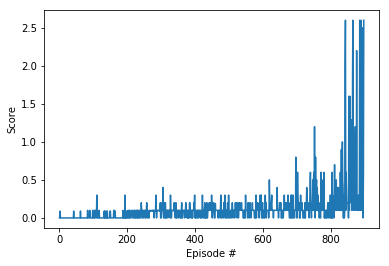

In [7]:
scores = ddpg_multiple()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score') 
plt.xlabel('Episode #')
plt.show()